# CIFAR-10 Transfer Learning with ResNet50

Bu notebook CIFAR-10 dataseti üzərində transfer öyrənmə tətbiq edir.
ResNet50 modeli ImageNet üzərində əvvəlcədən təlim keçmiş və CIFAR-10 dataseti üçün uyğunlaşdırılmışdır.

In [1]:
# Lazımi kitabxanaların import edilməsi
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# GPU yoxlanılması
print("TensorFlow versiyası:", tf.__version__)
print("GPU mövcuddur:", tf.config.list_physical_devices('GPU'))

TensorFlow versiyası: 2.15.0
GPU mövcuddur: []


## 1. Data Hazırlanması

In [3]:
# CIFAR-10 dataseti yüklənir
print("CIFAR-10 dataseti yüklənir...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Data normallaşdırılır
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Sinif adları
class_names = ['təyyarə', 'avtomobil', 'quş', 'pişik', 'maral', 
               'it', 'qurbağa', 'at', 'gəmi', 'yük maşını']

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("Təlim dataseti şəkli:", x_train.shape)
print("Test dataseti şəkli:", x_test.shape)

CIFAR-10 dataseti yüklənir...
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d958be074577803d12ecdefd02955f39262c83c16fe9348329d7fe0b5c001ce so we will re-download the data.
170498071/170498071 [==============================] - 944s 6us/step
Təlim dataseti şəkli: (50000, 32, 32, 3)
Test dataseti şəkli: (10000, 32, 32, 3)


In [4]:
# Şəkilləri ResNet50 üçün uyğun ölçüyə gətirmək
# CIFAR-10 şəkilləri 32x32 ölçüsündədir, ResNet50 isə 224x224 gözləyir
def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, (224, 224))
        resized_images.append(resized_img)
    return np.array(resized_images)

# Şəkilləri yenidən ölçüləndirmək
print("Şəkillər yenidən ölçüləndirilir...")
# Təlim üçün ilk 5000 şəkil (sürətli olması üçün)
x_train_resized = resize_images(x_train[:5000])  
# Test üçün ilk 1000 şəkil
x_test_resized = resize_images(x_test[:1000])    

# Uyğun olaraq y_train və y_test-i də kəsmək
y_train_subset = y_train[:5000]
y_test_subset = y_test[:1000]

print("Yenidən ölçüləndirilmiş təlim dataseti şəkli:", x_train_resized.shape)
print("Yenidən ölçüləndirilmiş test dataseti şəkli:", x_test_resized.shape)

Şəkillər yenidən ölçüləndirilir...
Yenidən ölçüləndirilmiş təlim dataseti şəkli: (5000, 224, 224, 3)
Yenidən ölçüləndirilmiş test dataseti şəkli: (1000, 224, 224, 3)


## 2. Datasetdən nümunələr

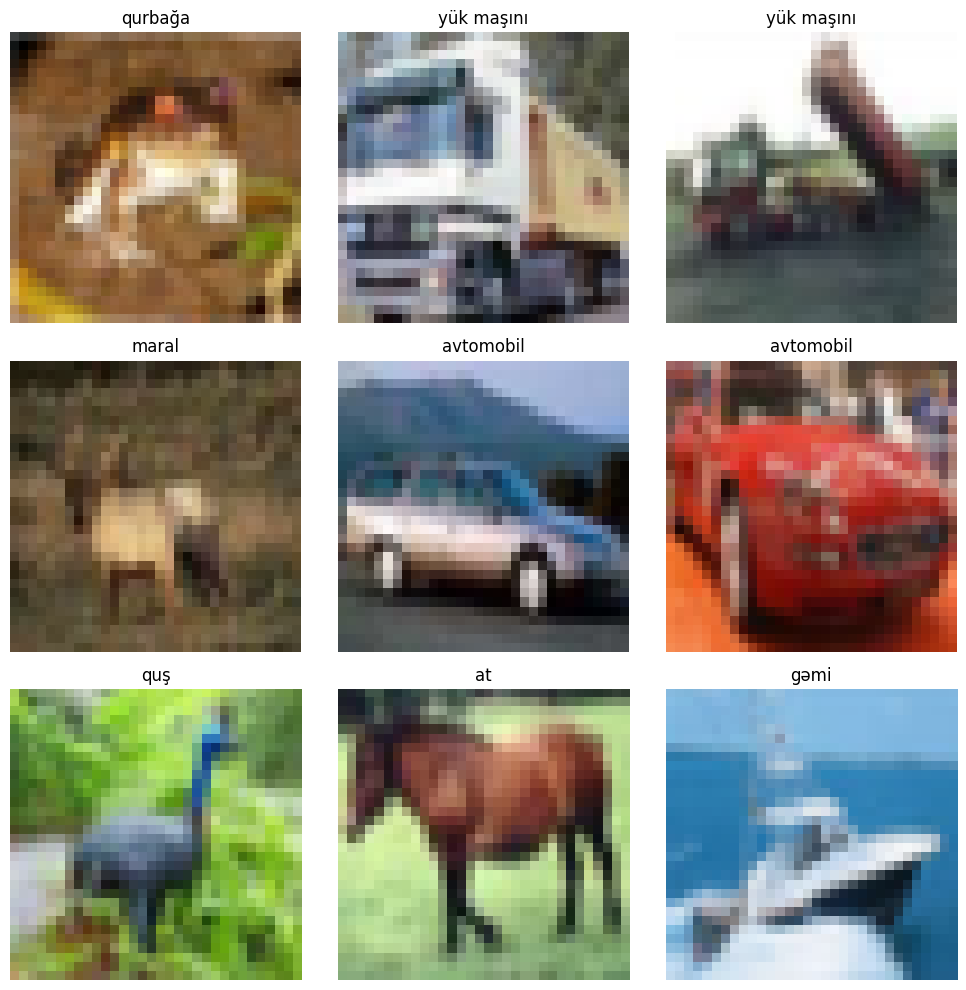

In [5]:
# Bəzi şəkilləri göstərmək
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis('off')
plt.tight_layout()

## 3. Transfer Öyrənmə Modelinin Qurulması

In [6]:
# Transfer öyrənmə üçün əvvəlcədən təlim keçmiş ResNet50 modelini yükləmək
print("ResNet50 modeli yüklənir...")
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Əsas modelin laylarını dondurmaq (təlim zamanı dəyişməmək üçün)
for layer in base_model.layers:
    layer.trainable = False

ResNet50 modeli yüklənir...




In [7]:
# Yeni model yaratmaq
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')  # CIFAR-10 üçün 10 sinif
])

# Modeli kompilyasiya etmək
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
# Modelin xülasəsi
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

## 4. Modelin Təlimi

In [9]:
# Callback-lər
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_cifar10_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [10]:
# Modeli təlim etmək
print("Model təlim edilir...")
start = time.time()
history = model.fit(
    x_train_resized,
    y_train_subset,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)
end = time.time()
print(f"Təlim vaxtı: {end - start:.2f} saniyə")

Model təlim edilir...
Epoch 1/10


125/125 [==============================] - ETA: 0s - loss: 2.4652 - accuracy: 0.1035
Epoch 1: val_accuracy improved from -inf to 0.09500, saving model to best_cifar10_model.h5
125/125 [==============================] - 249s 2s/step - loss: 2.4652 - accuracy: 0.1035 - val_loss: 2.3062 - val_accuracy: 0.0950
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 2.3542 - accuracy: 0.1042
Epoch 2: val_accuracy improved from 0.09500 to 0.10500, saving model to best_cifar10_model.h5
125/125 [==============================] - 129s 1s/step - loss: 2.3542 - accuracy: 0.1042 - val_loss: 2.3076 - val_accuracy: 0.1050
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 2.3301 - accuracy: 0.1047
Epoch 3: val_accuracy did not improve from 0.10500
125/125 [==============================] - 128s 1s/step - loss: 2.3301 - accuracy: 0.1047 - val_loss: 2.3001 - val_accuracy: 0.1010
Epoch 4/10
125/125 [==============================] - ET

## 5. Təlim Nəticələrinin Qiymətləndirilməsi

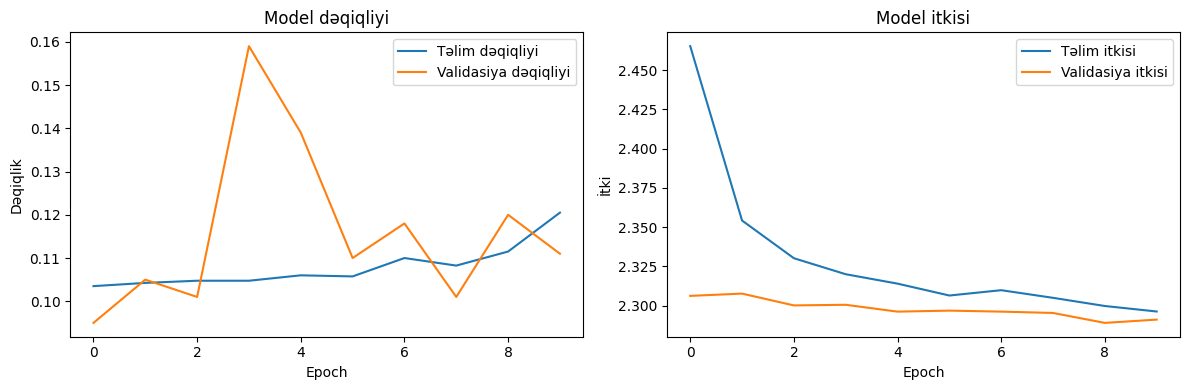

In [11]:
# Təlim nəticələrini qiymətləndirmək
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Təlim dəqiqliyi')
plt.plot(history.history['val_accuracy'], label='Validasiya dəqiqliyi')
plt.title('Model dəqiqliyi')
plt.xlabel('Epoch')
plt.ylabel('Dəqiqlik')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Təlim itkisi')
plt.plot(history.history['val_loss'], label='Validasiya itkisi')
plt.title('Model itkisi')
plt.xlabel('Epoch')
plt.ylabel('İtki')
plt.legend()
plt.tight_layout()

In [12]:
# Modeli test etmək
print("Model test edilir...")
test_loss, test_acc = model.evaluate(x_test_resized, y_test_subset)
print(f"Test dəqiqliyi: {test_acc:.4f}")
print(f"Test itkisi: {test_loss:.4f}")

Model test edilir...
32/32 [==============================] - 25s 777ms/step - loss: 2.2876 - accuracy: 0.1320
Test dəqiqliyi: 0.1320
Test itkisi: 2.2876


## 6. Proqnozların Vizuallaşdırılması

In [13]:
# Proqnozlar
predictions = model.predict(x_test_resized)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_subset, axis=1)

32/32 [==============================] - 27s 781ms/step


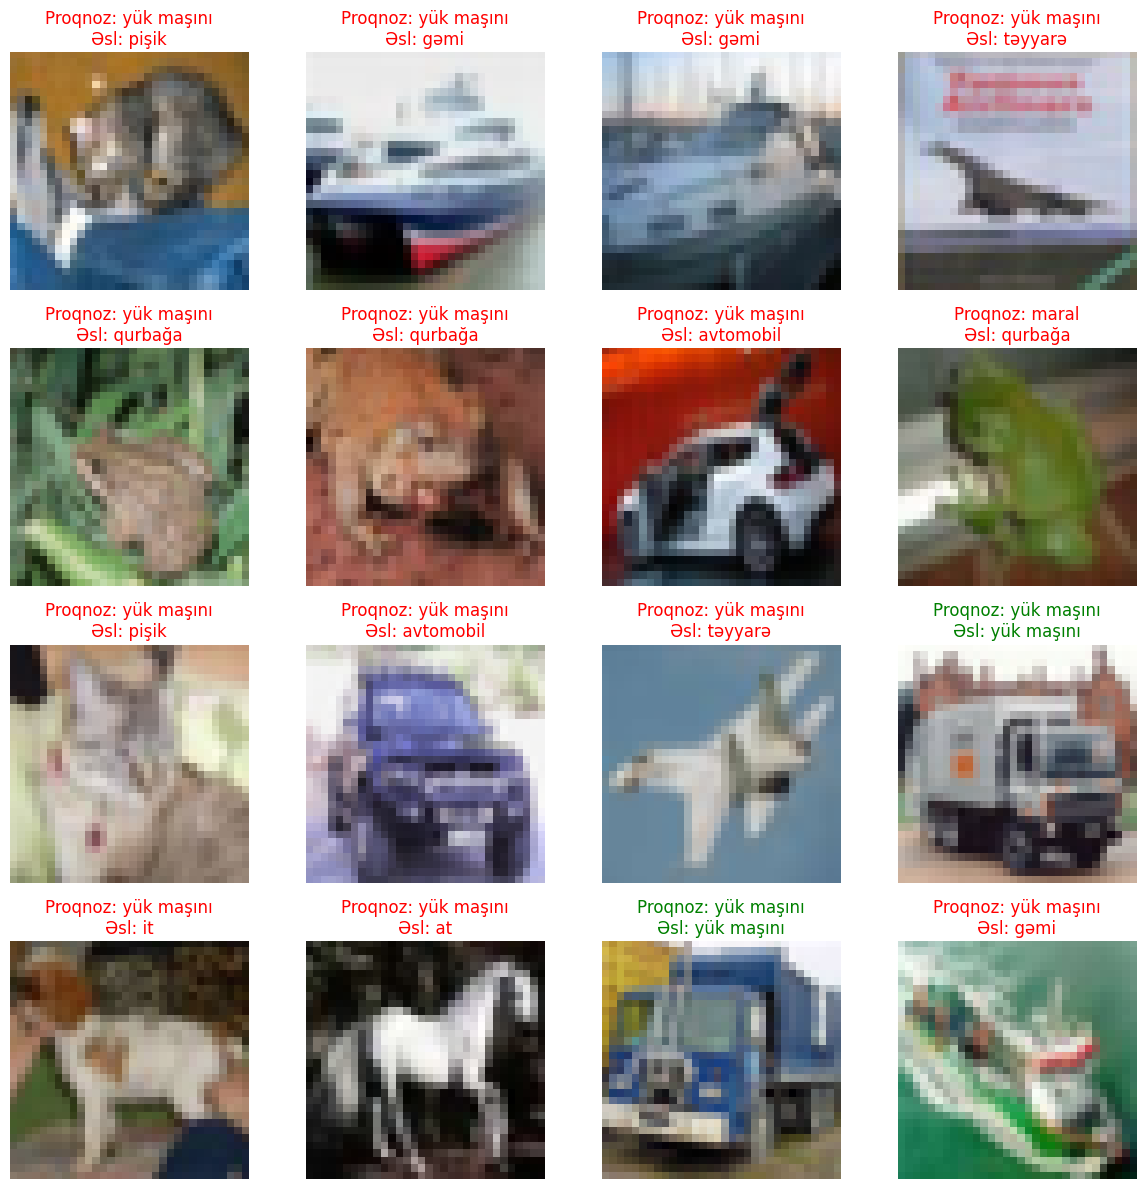

In [14]:
# Bəzi proqnozları göstərmək
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_test[i])
    predicted_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"Proqnoz: {predicted_label}\nƏsl: {true_label}", color=color)
    plt.axis('off')
plt.tight_layout()

## 7. Modelin Saxlanılması

In [15]:
# Modeli saxlamaq
model.save('cifar10_resnet50_model.h5')
print("Model saxlanıldı: cifar10_resnet50_model.h5")
print("Transfer öyrənmə tamamlandı!")

Model saxlanıldı: cifar10_resnet50_model.h5
Transfer öyrənmə tamamlandı!
